In [1]:
import numpy as np
from matplotlib import pyplot as plt
from ts_modelling.data_producer import DataProducer
from ts_modelling.simple_experiment import SimpleExp
from argparse import Namespace
import yaml
%matplotlib inline

with open('args.yaml', 'r') as file:
    config = yaml.safe_load(file)
args = Namespace(**config)
exp = SimpleExp(args)

length = 5000

Use CPU


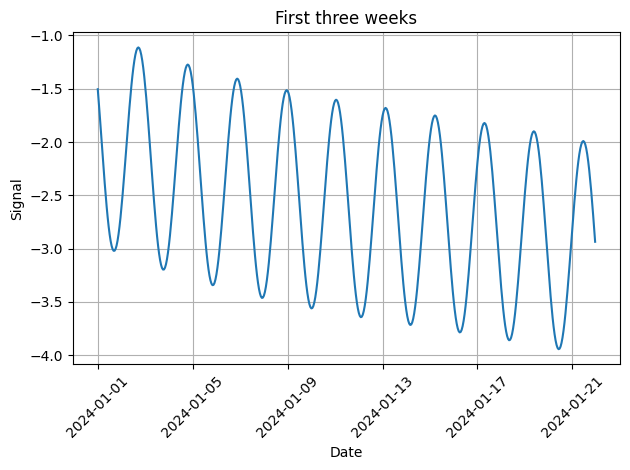

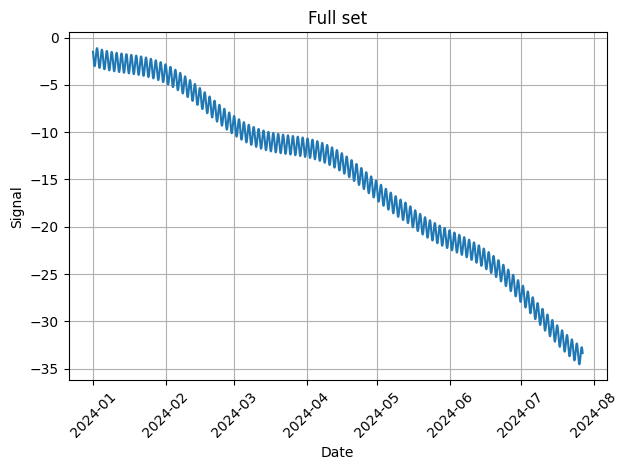

In [2]:
dp = DataProducer(length=length, n_vars=1, path=args.root_path, noise_amp=0)
dp.add_sine(freq_amp=[(3/length,1), (100/length, 1)])
dp.add_trend(nbr_trends=2, slope=50/length)
dp.plot_data()

In [3]:
dp.generate_csv()

In [4]:
dp.df

,date,signal_1
0,2024-01-01 00:00:00,-1.504673
1,2024-01-01 01:00:00,-1.624110
2,2024-01-01 02:00:00,-1.748847
3,2024-01-01 03:00:00,-1.876980
4,2024-01-01 04:00:00,-2.006551
...,...,...
4995,2024-07-27 03:00:00,-32.946442
4996,2024-07-27 04:00:00,-33.031106
4997,2024-07-27 05:00:00,-33.127570
4998,2024-07-27 06:00:00,-33.234431


In [2]:
exp.train()

train 2973
val 309
test 809
Validation loss decreased (inf --> 0.001439).  Saving model ...
Updating learning rate to 5.774693366163212e-05
Validation loss decreased (0.001439 --> 0.000932).  Saving model ...
Updating learning rate to 9.397136860148879e-09
Total training time: 0.0 minutes 16.421077013015747 seconds


<All keys matched successfully>

In [4]:
import os
os.makedirs(args.root_path, exist_ok=True)
data_path = os.path.join(args.root_path, 'custom')
dp.df.to_csv(data_path, index=False)

In [4]:
import os
os.path.join(args.root_path, 'då')

'./data/då'